In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data Pre-processing

The data consists of the artifactual variant calls that differ from the GIAB high confidence calls produced by the NGS pipeline.

Below define a dictionary of your XRR accessions and their associated class. Here, 0 = hybrid capture, and 1 = PCR

In [3]:
srx_dict = {'ERR1831349': 0, 'ERR1905889': 0, 'ERR1905890': 0, 'ERR1831350': 0, 
            'ERR032972': 1, 'SRR1620964': 1, 'ERR1679737': 1, 'ERR032971': 1}

Import each tab_delimited artifacts file as a dataframe and add the associated class as a column. Append all dataframes together.

In [4]:
data = pd.DataFrame(columns = ['#CHROM\tPOS\tREF\tALT', 'y'])
directory = '/home/ztom/pipeline/artifacts/all'
for filename in os.listdir(directory):
    #do not parse tabs so that data is read in as one column
    df = pd.read_csv(os.path.join(directory,filename), header=0)
    df = df.dropna()
    df['y'] = srx_dict[filename.split('_')[0]]
    print(df.shape)
    print(list(df.columns))
    data = pd.concat([data, df], ignore_index=True)
print(data.shape)


(22183, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(62970, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(44695, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(73705, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(5377, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(483, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(25905, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(71257, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(306575, 2)


Clean up the data for readability

In [5]:
data = data.replace({'\t':'/'}, regex=True)
data.columns = ['CHROM_POS_REF_ALT', 'y']
data.head()

,CHROM_POS_REF_ALT,y
0,chr10/169950/CACCAA/CA/,0
1,chr10/170475/AAATGAATGA/AAATGA/,0
2,chr10/217125/CT/CTTT/,0
3,chr10/239537/TTGT/TTGTGT/,0
4,chr10/277066/GTTTT/GTTTTT/,0


#### Input variables

1 - chromosome / position / reference allele / artifact allele (categorical)

#### Predict variable (desired target):

y - what type of enrichment was performed? Hybrid capture or PCR? (binary: 1 / 0)

## Data exploration

### Evaluate Redundancy

Every sequence read run consists of a set of mostly unique artifacts. Between sequencing runs, we want to see a number of repeat artifacts to indicate a pattern that can be potentially attributed to sample manipulation / library construction protocol variables. The fraction of repeat artifacts for this dataset is seen below:

In [6]:
print('Number of unique artifacts: ', data['CHROM_POS_REF_ALT'].unique().size)
print('Percentage of unique artifacts: {:.2f}'.format(1 - data['CHROM_POS_REF_ALT'].unique().size/data.shape[0]))

Number of unique artifacts:  192157
Percentage of unique artifacts: 0.37


### Evaluate Balance

We want a relatively equal proportion of classes in the dataset. If there is an imbalance, oversmapling can be conducted.

In [7]:
data['y'].value_counts()

0    155753
1    150822
Name: y, dtype: int64

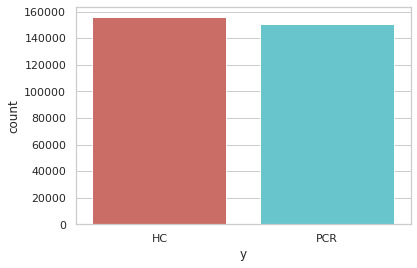

In [8]:
sns.countplot(x='y',data=data, palette='hls')
plt.xticks(np.arange(2), ['HC','PCR'])
plt.show()

In [9]:
count_HC = len(data[data['y']==0])
count_PCR = len(data[data['y']==1])
pct_of_HC = count_HC/(count_HC+count_PCR)
print("percentage of HC is {:.2f}".format(pct_of_HC*100))
pct_of_PCR = count_PCR/(count_HC+count_PCR)
print("percentage of PCR is {:.2f}".format(pct_of_PCR*100))

percentage of HC is 50.80
percentage of PCR is 49.20


The classes are well balanced between hybrid capture and polymerase chain reaction

### Data Visualizations

Let's take a look at the n most frequent artifacts found in the dataset to see if any are a good predictor of the outcome variable. Operating under the assumption that the more frequently an artifacts appears, the more likely it has a specific cause. 

In [10]:
n = 20
print(data['CHROM_POS_REF_ALT'].value_counts()[:n])
most_frequent_artifact = data['CHROM_POS_REF_ALT'].value_counts()[:n].index.tolist()
mfas = data[data['CHROM_POS_REF_ALT'].isin(most_frequent_artifact)].CHROM_POS_REF_ALT
mfcs = data[data['CHROM_POS_REF_ALT'].isin(most_frequent_artifact)].y
#shorten the artifact names for plot readability
mfas = mfas.apply(lambda x: x[:14])

chr12/19473376/AATTTATTTATTTATTTATTTATTTATTTATTTATTTATTTATTTAT/AATTTATTTATTTATTTATTTATTTATTTATTTATTTATTTAT/             24
chr14/91881120/TACACACACACACACACACACACACACACACACAC/TACACACACACACACACACACACACAC/                                         20
chr1/66776560/GGTGTGTGTGTGTGTGTGT/GGTGTGTGTGTGTGTGTGTGT/                                                                16
chr22/26408789/ACCTTCCTTCCTTCCTTCCTTC/ACCTTCCTTCCTTCCTTC/                                                               15
chr7/96990932/TAGAGAGAGAGAGAGAGAGAGA/TAGAGAGAGAGAGAGAGA/                                                                12
chr6/38412860/AAACAACAACAACAACAACAACAACAA/AAACAACAACAACAACAACAACAA/                                                     12
chr3/151827533/GTTTT/GTTT/                                                                                              12
chr1/57198649/TCACACACACACACACACACACACACACACACACACACACAC/TCACACACACACACACACACACACACACACACACACACACACACACAC/              12
chr5/65704035/CA

Text(0, 0.5, 'Frequency')

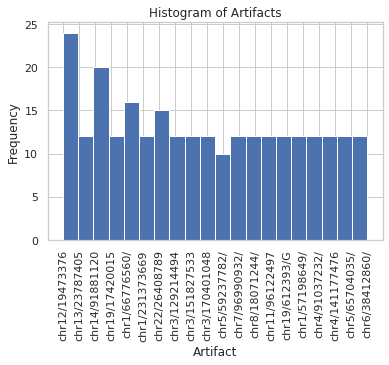

In [11]:
plt.hist(mfas, 20)
plt.xticks(rotation='vertical')
plt.title('Histogram of Artifacts')
plt.xlabel('Artifact')
plt.ylabel('Frequency')

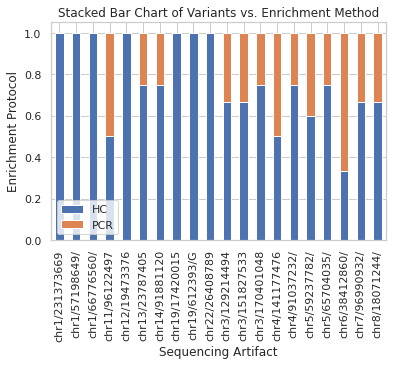

In [12]:
table=pd.crosstab(mfas,mfcs)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Variants vs. Enrichment Method')
plt.xlabel('Sequencing Artifact')
plt.ylabel('Enrichment Protocol')
plt.legend(['HC', 'PCR'], loc='lower left')
#plt.figure(figsize=(20,10))

Based on the results, these artifacts appear to be a good predictor of enrichment protocol step, with hybrid capture producing the majority of frequently occuring artifacts, except for in the case of artifacts chromosome 11 at position 96122497, chrosome 4 at position 141177476, and chromosome 6 at position 38412860.

## Target Encoding

Because there are 192,157 unique categorical values for the artifact feature, one-hot encoding is not feasible. Attepts to produce dummy variables with one-hot encoding results in kernel crash likely due to running out of memory. Thus, target encoding is used.

In [13]:
encoder = TargetEncoder()
data['CHROM_POS_REF_ALT Encoded'] = encoder.fit_transform(data['CHROM_POS_REF_ALT'], data['y'])
    
print(data.head())
data_final=data[['CHROM_POS_REF_ALT Encoded','y']]
data_final.columns.values

/home/ztom/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


                 CHROM_POS_REF_ALT  y  CHROM_POS_REF_ALT Encoded
0          chr10/169950/CACCAA/CA/  0                   0.491958
1  chr10/170475/AAATGAATGA/AAATGA/  0                   0.132308
2            chr10/217125/CT/CTTT/  0                   0.261475
3        chr10/239537/TTGT/TTGTGT/  0                   0.058643
4       chr10/277066/GTTTT/GTTTTT/  0                   0.023332


array(['CHROM_POS_REF_ALT Encoded', 'y'], dtype=object)

## Logistic Regression Model Fitting

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = data_final.loc[:, 'CHROM_POS_REF_ALT Encoded']
y = data_final.loc[:, 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#reshape data because we have one feature
X_train_reshaped = X_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)

logreg = LogisticRegression()
logreg.fit(X_train_reshaped, y_train)

LogisticRegression()

In [15]:
y_pred = logreg.predict(X_test_reshaped)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_reshaped, y_test)))

Accuracy of logistic regression classifier on test set: 0.71


## Results Analysis

### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[23647 23281]
 [ 3734 41311]]


These results tell us that we have 23647+41311 correct predictions and 3734+23281 incorrect predictions.

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.50      0.64     46928
           1       0.64      0.92      0.75     45045

    accuracy                           0.71     91973
   macro avg       0.75      0.71      0.70     91973
weighted avg       0.75      0.71      0.69     91973



#### Interpretation:

Of the entire test set, 71% of the predicted enrichment steps were the enrichment step associated with the corresponding artifact.

### ROC Curve

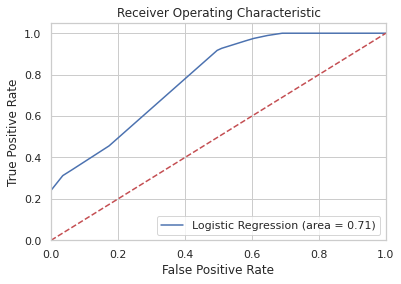

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_reshaped))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_reshaped)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The Area Under Curve (AUC) is within the 0.7 - 0.8 range, so not outstanding but acceptable.